## Notes

### Overview
This notebook captures a series of tests performed on the Raspberry Pi 2 with the Adafruit BNO055 9-dof IMU sensor board.  The main goals for the tests were: 
- demonstrate the ability to launch a secondary python process, which periodically samples from the IMU sensor and stores measurements in a fixed size buffer that is accessible from the main process.
- demonstrate the ability to synchronize reads from (Consumer) and write to (Producer) the shared buffer
- characterize the behavior of the uniform sampling and buffering process (Producer) when the Consumer process has significant latency
- characterize the results of applying bandpass filtering techniques to the buffered data on the Consumer side

### Implementation Details
- Candidate Implementation 1:
 - Parent defines the size of the data buffers and creates four buffers: x, y, z, t
 - Child process tries to fill data buffers with contiguous samples
 - Buffers are not readable until they are full
 - If a sample is missed, the buffers are cleared, filling starts over (this may be too conservative)
 - When the reader reads the buffers, they are cleared so filling can start over (this should ensure independence between read samples)
- Candidate Implementation 2:
 - Consumer notifies producer that a measurement is needed
 - Producer then fills up buffers and notifies consumer when data is ready
 - Consumer notifies Producer when data successfully consumed

Note: the implementation of the underlying periodic wakeups and serial communications were prototyped and documented in the following notebook: sandboxes/ipython_notebooks/imu_sample_rate_tests_3.ipynb

### Test Design
- Experiment 1: Fill buffer once, from spawned process
 - Consumer initializes 4 M-length data buffers (t,x,y,z) from shared memory
 - Consumer spawns child process to execute Producer code
 - Producer code uses setitimer() to periodically wake up and attempt to read measurements
 - Producer fills shared buffers with measurement and timing info until a stop condition occurs
 - Verify shared buffers contain valid data at end of test
- Experiment 2: Producer-Consumer, N reads, post-hoc signal processing
 - Consumer initializes 4 M-length data buffers (t,x,y,z) from shared memory (shmem)
 - Consumer initializes a "buffer offset" variable from shmem to track buffer fullness
 - Consumer initializes a mutex and condition variable for Producer Consumer syncronization
 - Consumer spawns child process to execute Producer code, passing in data buffers, buffer offset variable, and syncronization objects
 - Producer code uses setitimer() to periodically wake up and attempt to read measurements
 - Producer fills shared buffers with measurement and timing info until a stop condition occurs
 - Producer signals Consumer (via condition variable) when buffers are full
 - Consumer waits on condition variable signal then reads all buffers and resets buffer offset
 - Consumer performs arbitrary, timed sleep operation to simulate latency
 - At end of test, verify buffered reads contained valid data
 - offline: Apply bandpass filter results data and examine filtered signals

Note: In both experiments, IMU sensor and RPi were mounted on a 4-wheel rover, but the rover was stationary
 
### Conclusions
These experiments successfully demonstrated the ability to repeatedly Produce and Consume buffered data, in a syncronized fashion, with acceptable sampling uniformity within a given buffered data set.  This is all promising for the prospects of running a soft-realtime IMU sensor process in parallel with motor control and mission planning processes.  

### Next Steps
The next step is to run a sensor test similar to Experiment 2 while inducing real motion on the rover.  The goal of doing so is to further characterize the raw and filtered sensor signals under non-stationary conditions.

## Component Code

In [268]:
%matplotlib inline
from __future__ import division
import time
import sys
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np

In [53]:
from Adafruit_BNO055 import BNO055
import serial
from serial.serialutil import SerialException

class BNO055_2(BNO055.BNO055):
    def __init__(self, rst=None, address=BNO055.BNO055_ADDRESS_A, i2c=None, gpio=None,
                 serial_port=None, serial_timeout_sec=5, baudrate=115200, 
                 max_send_attempts=5, **kwargs):
        # If reset pin is provided save it and a reference to provided GPIO
        # bus (or the default system GPIO bus if none is provided).
        self._rst = rst
        if self._rst is not None:
            if gpio is None:
                import Adafruit_GPIO as GPIO
                gpio = GPIO.get_platform_gpio()
            self._gpio = gpio
            # Setup the reset pin as an output at a high level.
            self._gpio.setup(self._rst, GPIO.OUT)
            self._gpio.set_high(self._rst)
            # Wait a 650 milliseconds in case setting the reset high reset the chip.
            time.sleep(0.65)
        self._max_send_attempts=max_send_attempts
        self._serial = None
        self._i2c_device = None
        if serial_port is not None:
            # Use serial communication if serial_port name is provided.
            # Open the serial port at 115200 baud, 8N1.  Add a 5 second timeout
            # to prevent hanging if device is disconnected.
            self._serial = serial.Serial(serial_port, baudrate, timeout=serial_timeout_sec,
                                         writeTimeout=serial_timeout_sec)
        else:
            raise AttributeError('No valid serial interface specified.')
        # - Brief pause to make sure everything finishes initializing (maybe not necessary)
        time.sleep(0.001)
        
    def _serial_send(self, command, ack=True, max_attempts=5):
        # Send a serial command and automatically handle if it needs to be resent
        # because of a bus error.  If ack is True then an ackowledgement is
        # expected and only up to the maximum specified attempts will be made
        # to get a good acknowledgement (default is 5).  If ack is False then
        # no acknowledgement is expected (like when resetting the device).
        attempts = 0
        while True:
            # Flush any pending received data to get into a clean state.
            self._serial.flushInput()
            # Send the data.
            self._serial.write(command)
            #logger.debug('Serial send: 0x{0}'.format(binascii.hexlify(command)))
            # Stop if no acknowledgment is expected.
            if not ack:
                return
            # Read acknowledgement response (2 bytes).
            resp = bytearray(self._serial.read(2))
            #logger.debug('Serial receive: 0x{0}'.format(binascii.hexlify(resp)))
            if resp is None or len(resp) != 2:
                raise RuntimeError('Timeout waiting for serial acknowledge, is the BNO055 connected?')
            # Stop if there's no bus error (0xEE07 response) and return response bytes.
            if not (resp[0] == 0xEE and resp[1] == 0x07):
                return resp
            # Else there was a bus error so resend, as recommended in UART app
            # note at:
            #   http://ae-bst.resource.bosch.com/media/products/dokumente/bno055/BST-BNO055-AN012-00.pdf
            attempts += 1
            if attempts >=  self._max_send_attempts:
                raise RuntimeError('Exceeded maximum attempts to acknowledge serial command without bus error!')

In [4]:
def wakeup_handler(signum, frame):
    global wakeup_set, wakeup_wrap
    if wakeup_set:
        wakeup_wrap = True
    wakeup_set = True

def initialize_sensor_itimer(wakeup_interval_usec):
    import signal
    # Define sigaction for SIGALRM
    signal.signal(signal.SIGALRM,wakeup_handler)
    signal.setitimer(signal.ITIMER_REAL,wakeup_interval_usec*1e-6,wakeup_interval_usec*1e-6)
    
def cleanup_itimer():
    import signal
    signal.setitimer(signal.ITIMER_REAL,0,0)

def finalize_wakeup_attempt():
    global wakeup_set, wakeup_count, read_started, read_completed
    wakeup_set = False
    wakeup_count += 1
    read_started = False
    read_completed = True
    

## Experiments

### Experiment 1: Fill buffer once, from spawned process

In [44]:
def run_serial_buffer_test_1(
    num_samples, 
    sample_interval_usec, 
    max_read_retries, 
    t_array,
    x_array, 
    y_array, 
    z_array):
    
    # Reset global variables (Probably necessary for repeated runs in iPython)
    global wakeup_count, wakeup_set, read_started, read_completed, wakeup_wrap
    wakeup_count = 0
    wakeup_set = 0
    read_started = 0
    read_completed = 0
    wakeup_wrap = 0
    
    # Compute operational constants
    max_time_sec = 10 * num_samples * sample_interval_usec * 1.0e-6 # Extra factor of 10, so we don't get cutoff prematurely

    
    # Create serial adapter and initialize BNO055 sensor
    imu = BNO055_2(
        serial_port='/dev/ttyAMA0', 
        rst=18, 
        baudrate=115200,
        max_send_attempts=max_read_retries)
    
    
    # - Repeatedly Pole Sensor until end of test
    loop_count, success_count, comm_fail_count = 0,0,0
    wrap_count, max_comm_fail_count = 0,0
    duration, heartbeat_duration = 0,0
    
    # Initialize buffer management
    buffer_offset = 0
    buffer_size = len(t_array)
    print 'buffer_size: ',buffer_size
    
    # Initialize timers
    start_time = time.time()
    heartbeat_time = start_time
    
    try:
        # Initialize the interupt timer for periodic wakeups
        initialize_sensor_itimer(wakeup_interval_usec=sample_interval_usec)
        
        while True:
            loop_count+=1        
            if (loop_count % 100) == 0:
                current_time = time.time()
                duration = current_time - start_time
                if duration >= max_time_sec:
                    raise ValueError('Max program duration exceeded')
            if (loop_count > 100*1e6):
                raise ValueError('Max program loop count exceeded')
            if (wakeup_count > num_samples):
                raise ValueError('Max read attempts exceeded')
            
            # - Come in here if a scheduled wakeup occurred and has not been marked complete (by success or failure)
            if wakeup_set:
                # - Handle wakeup wrap condition
                if wakeup_wrap:
                    wakeup_wrap = False
                    wrap_count += 1
                    finalize_wakeup_attempt()
                    # In the case of wakeup wrap, keep wakeup_set true, but count the failed attempt
                    wakeup_set = True
                
                # Indicate that we have started trying to read from the sensor for the current scheduled wakeup
                read_started = 1
                read_completed = 0
        
                # DEBUG - Try to sleep for 1 sec, but expect to be interrupted
                #time.sleep(.01)
                # TODO: replace sleep with attempt to read linear accel (using max_read_retries)
                try:
                    if buffer_offset < buffer_size:
                        x, y, z = imu.read_linear_acceleration()
                        # - Debug code
                        #if x != 0.0 or y != 0.0 or z != 0.0:
                        #    print 'Non-zero measurements: {0}, {1}, {2}'.format(x,y,z)
                        t_array[buffer_offset] = time.time()
                        x_array[buffer_offset] = x
                        y_array[buffer_offset] = y
                        z_array[buffer_offset] = z
                        buffer_offset += 1
                except RuntimeError as err:
                    print 'Runtime Exception: {}'.format(err)
                    continue
                except SerialException as err:
                    print 'Serial Exception: {}'.format(err)
                    continue
                except:
                    #print 'Unknown exception on wakeup: {}'.format(wakeup_count)
                    continue
                
                success_count += 1
                finalize_wakeup_attempt()
    
    except ValueError as err:
        print 'Program ended: {}'.format(err)
    finally:
        cleanup_itimer()
        
    # - Cleanup after main program loop
    print 'Program duration (sec): {:0.1f}'.format(duration)
    print 'Total loop count: {}'.format(loop_count)
    print 'Read attempts: {}'.format(wakeup_count)
    print 'Sensor sample interval (ms): {:0.1f}'.format(sample_interval_usec/1000);
    print 'Successful reads: {}'.format(success_count)
    #printf("Max comm failure occurrences: %d\n",max_comm_fail_count);
    print 'Wakeup wrap count: {}'.format(wrap_count);
    print 'Read success rate: {:0.3f}'.format(success_count/wakeup_count);


In [51]:
from multiprocessing import Process, Array
import time

buffer_size = 10
num_samples=50
sample_interval_usec=10000
max_read_retries=5

t_arr = Array('d', range(buffer_size))
x_arr = Array('d', range(buffer_size))
y_arr = Array('d', range(buffer_size))
z_arr = Array('d', range(buffer_size))

p = Process(
    target=run_serial_buffer_test_1, 
    args=(
        num_samples,
        sample_interval_usec,
        max_read_retries,
        t_arr,x_arr,y_arr,z_arr))

launch_start_time = time.time()
p.start()
p.join()

buffer_size:  10
Program ended: Max read attempts exceeded
Program duration (sec): 0.5
Total loop count: 44535
Read attempts: 51
Sensor sample interval (ms): 10.0
Successful reads: 50
Wakeup wrap count: 1
Read success rate: 0.980


In [52]:
print [t - launch_start_time for t in t_arr[:]]
print x_arr[:]
print y_arr[:]
print z_arr[:]

[0.8246440887451172, 0.8375060558319092, 0.8473320007324219, 0.8575870990753174, 0.8673200607299805, 0.8773090839385986, 0.8874151706695557, 0.8973000049591064, 0.9073150157928467, 0.917316198348999]
[0.01, 0.01, 0.0, 0.01, 0.01, 0.01, 0.02, 0.02, 0.01, 0.03]
[-0.03, 0.0, 0.0, -0.02, 0.0, -0.01, -0.01, -0.01, -0.01, -0.02]
[0.06, 0.07, 0.1, 0.09, 0.03, 0.08, 0.07, 0.09, 0.05, -0.02]


### Experiment 2: Producer-Consumer, N reads, post-hoc signal processing

In [181]:
def run_serial_buffer_test_2(
    num_samples, 
    sample_interval_usec, 
    max_read_retries, 
    t_array,
    x_array, 
    y_array, 
    z_array,
    buffer_offset,
    buffer_full_condition,
    buffer_mutex):
    
    # Reset global variables (Probably necessary for repeated runs in iPython)
    global wakeup_count, wakeup_set, read_started, read_completed, wakeup_wrap
    wakeup_count = 0
    wakeup_set = 0
    read_started = 0
    read_completed = 0
    wakeup_wrap = 0
    
    # Compute operational constants
    max_time_sec = 10 * num_samples * sample_interval_usec * 1.0e-6 # Extra factor of 10, so we don't get cutoff prematurely

    
    # Create serial adapter and initialize BNO055 sensor
    imu = BNO055_2(
        serial_port='/dev/ttyAMA0', 
        rst=18, 
        baudrate=115200,
        max_send_attempts=max_read_retries)
    
    
    # - Repeatedly Pole Sensor until end of test
    loop_count, success_count, comm_fail_count = 0,0,0
    wrap_count, max_comm_fail_count = 0,0
    duration, heartbeat_duration = 0,0
    
    # Initialize buffer management
    buffer_size = len(t_array)
    print 'buffer_size: ',buffer_size
    
    # Initialize timers
    start_time = time.time()
    heartbeat_time = start_time
    
    try:
        # Initialize the interupt timer for periodic wakeups
        initialize_sensor_itimer(wakeup_interval_usec=sample_interval_usec)
        
        while True:
            loop_count+=1        
            if (loop_count % 100) == 0:
                current_time = time.time()
                duration = current_time - start_time
                if duration >= max_time_sec:
                    raise ValueError('Max program duration exceeded')
            if (loop_count > 100*1e6):
                raise ValueError('Max program loop count exceeded')
            if (wakeup_count > num_samples):
                raise ValueError('Max read attempts exceeded')
            
            # - Come in here if a scheduled wakeup occurred and has not been marked complete (by success or failure)
            if wakeup_set:
                # - Handle wakeup wrap condition
                if wakeup_wrap:
                    wakeup_wrap = False
                    wrap_count += 1
                    finalize_wakeup_attempt()
                    # In the case of wakeup wrap, keep wakeup_set true, but count the failed attempt
                    wakeup_set = True
                    # DEBUG
                    #print 'Wakeup wrap!'
                
                # Indicate that we have started trying to read from the sensor for the current scheduled wakeup
                read_started = 1
                read_completed = 0
        
                # - Attempt to read linear accel (using max_read_retries)
                try:
                    # DEBUG
                    #print 'Buffer offset: ',buffer_offset.value
                    # Get lock for buffers
                    buffer_mutex.acquire()
                    # TODO: This could be improved by implementing as a FIFO that always has the "freshest possible data"
                    if buffer_offset.value < buffer_size:
                        x, y, z = imu.read_linear_acceleration()
                        t_array[buffer_offset.value] = time.time()
                        x_array[buffer_offset.value] = x
                        y_array[buffer_offset.value] = y
                        z_array[buffer_offset.value] = z
                        buffer_offset.value += 1
                        # Notify consumer that full buffer is ready to read
                        if buffer_offset.value >= buffer_size:
                            buffer_full_condition.acquire()
                            buffer_full_condition.notify()
                            buffer_full_condition.release()
                    # Release lock on buffers
                    buffer_mutex.release()
                            
                except RuntimeError as err:
                    print 'Runtime Exception: {}'.format(err)
                    continue
                except SerialException as err:
                    print 'Serial Exception: {}'.format(err)
                    continue
                except:
                    exc_type, exc_value = sys.exc_info()[:2]
                    print 'Unknown exception on wakeup: {0}\n{1}\n{2}'.format(
                        wakeup_count,
                        exc_type,
                        exc_value)
                    print 'about to release lock in child due to exception, buffer offset: ',buffer_offset.value
                    buffer_mutex.release()
                    #raise
                    continue
                
                success_count += 1
                finalize_wakeup_attempt()
    
    except ValueError as err:
        print 'Program ended: {}'.format(err)
    finally:
        cleanup_itimer()
        
    # - Cleanup after main program loop
    print 'Program duration (sec): {:0.1f}'.format(duration)
    print 'Total loop count: {}'.format(loop_count)
    print 'Read attempts: {}'.format(wakeup_count)
    print 'Sensor sample interval (ms): {:0.1f}'.format(sample_interval_usec/1000);
    print 'Successful reads: {}'.format(success_count)
    #printf("Max comm failure occurrences: %d\n",max_comm_fail_count);
    print 'Wakeup wrap count: {}'.format(wrap_count);
    print 'Read success rate: {:0.3f}'.format(success_count/wakeup_count);


In [248]:
import multiprocessing as mproc
import time
import math

buffer_size = 10
num_samples=50
sample_interval_usec=10000
max_read_retries=5

buffer_full_condition = mproc.Condition()
buffer_mutex = mproc.Lock()

t_arr = mproc.Array('d', range(buffer_size))
x_arr = mproc.Array('d', range(buffer_size))
y_arr = mproc.Array('d', range(buffer_size))
z_arr = mproc.Array('d', range(buffer_size))
buffer_offset = mproc.Value('i',0)

p = mproc.Process(
    target=run_serial_buffer_test_2, 
    args=(
        num_samples,
        sample_interval_usec,
        max_read_retries,
        t_arr,x_arr,y_arr,z_arr,
        buffer_offset,
        buffer_full_condition,
        buffer_mutex))

launch_start_time = time.time()
p.start()

all_times = []
all_x_data = []
all_y_data = []
all_z_data = []
for sample_ind in range(int(math.floor(num_samples/buffer_size))):
    # Wait for notification buffer is full
    buffer_full_condition.acquire()
    buffer_full_condition.wait(timeout=1)
    # Lock buffers from being modified while copying and resetting
    buffer_mutex.acquire()
    local_t = t_arr[:]
    local_x = x_arr[:]
    local_y = y_arr[:]
    local_z = z_arr[:]
    buffer_offset.value = 0
    # Unlock buffers
    buffer_mutex.release()
    time.sleep(0.5)
    buffer_full_condition.release()
    all_times.append([l_t - launch_start_time for l_t in local_t])
    all_x_data.append(local_x)
    all_y_data.append(local_y)
    all_z_data.append(local_z)
    
p.join(10)

#all_times.append([l_t - launch_start_time for l_t in local_t])

# Generate some output for debugging
print 'all measurement times:'
for buff_time in all_times:
    print '\t'.join(['{:.3f}'.format(t_str) for t_str in buff_time])


buffer_size:  10
Program ended: Max read attempts exceeded
Program duration (sec): 1.7
Total loop count: 36537
Read attempts: 51
Sensor sample interval (ms): 10.0
Successful reads: 47
Wakeup wrap count: 4
Read success rate: 0.922
all measurement times:
0.910	0.919	0.929	0.939	0.952	0.959	0.969	0.979	0.989	1.002
1.009	1.020	1.030	1.040	1.052	1.060	1.070	1.080	1.090	1.103
1.518	1.528	1.538	1.548	1.558	1.568	1.578	1.588	1.598	1.608
2.018	2.028	2.038	2.048	2.059	2.068	2.078	2.088	2.098	2.110
2.520	2.530	2.540	2.550	2.563	2.570	2.580	2.088	2.098	2.110


In [249]:
print len(all_z_data[0])
print all_z_data[0]

10
[0.08, 0.1, 0.01, 0.05, 0.1, 0.08, 0.05, 0.01, 0.04, 0.07]


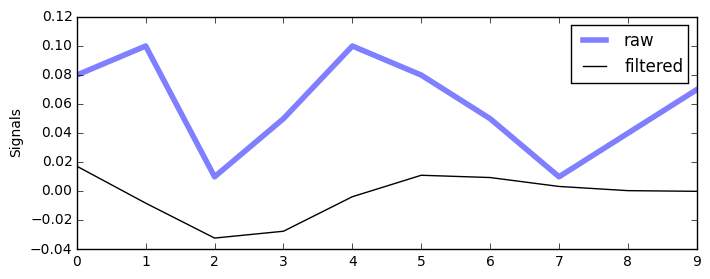

In [269]:
#sig_data = all_x_data[0]
#sig_data = all_y_data[0]
sig_data = all_z_data[0]

b, a = signal.butter(5, [0.1,0.50], 'bandpass', analog=False)
filt_data = signal.filtfilt(b,a,sig_data,padtype='odd',padlen=0)

fig, axes = plt.subplots(figsize=(8,3),nrows=1, ncols=1)
current_axes = axes
current_axes.plot(sig_data, linestyle='-', color='b', linewidth=4, alpha=0.5, label='raw')
current_axes.plot(filt_data, linestyle='-', color='k', linewidth=1, alpha=1.0, label='filtered')
current_axes.set_ylabel('Signals', fontsize=10)
current_axes.legend(loc='upper right')

## Sandbox

In [171]:
p.is_alive()

False

In [110]:
p.join()

In [198]:
%matplotlib inline
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np

numerator:  [ 0.0527864   0.26393202  0.52786405  0.52786405  0.26393202  0.0527864 ]
denominator:  [  1.00000000e+00  -4.16333634e-16   6.33436854e-01  -1.31860534e-16
   5.57280900e-02  -3.09353043e-18]


(-500, 50)

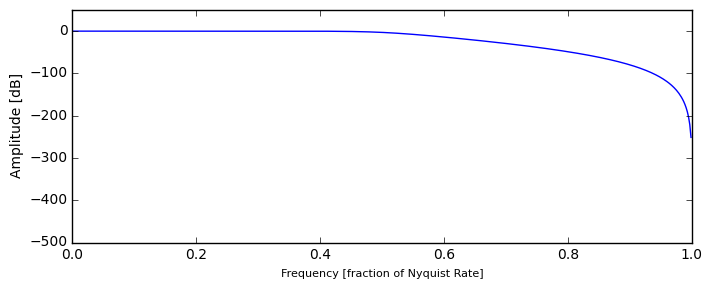

In [216]:
b, a = signal.butter(5, 0.5, 'low', analog=False)
w, h = signal.freqz(b,a)

print 'numerator: ',b
print 'denominator: ',a

fig, axes = plt.subplots(figsize=(8,3),nrows=1, ncols=1)
current_axes = axes
current_axes.plot(w/math.pi, 20 * np.log10(abs(h)), 'b')
current_axes.set_ylabel('Amplitude [dB]', fontsize=10)
current_axes.set_xlabel('Frequency [fraction of Nyquist Rate]', fontsize=8)
current_axes.set_ylim([-500,50])

numerator:  [ 0.7753166   3.87658298  7.75316595  7.75316595  3.87658298  0.7753166 ]
denominator:  [ 1.          4.49183097  8.09405542  7.31208128  3.31104756  0.60111582]


(-500, 50)

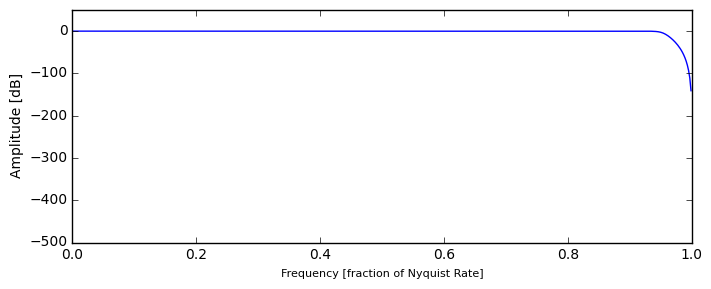

In [218]:
b, a = signal.butter(5, 0.95, 'low', analog=False)
w, h = signal.freqz(b,a)

print 'numerator: ',b
print 'denominator: ',a

fig, axes = plt.subplots(figsize=(8,3),nrows=1, ncols=1)
current_axes = axes
current_axes.plot(w/math.pi, 20 * np.log10(abs(h)), 'b')
current_axes.set_ylabel('Amplitude [dB]', fontsize=10)
current_axes.set_xlabel('Frequency [fraction of Nyquist Rate]', fontsize=8)
current_axes.set_ylim([-500,50])

numerator:  [ 0.5999402   0.         -2.99970102  0.          5.99940204  0.
 -5.99940204  0.          2.99970102  0.         -0.5999402 ]
denominator:  [  1.00000000e+00  -1.77635684e-15  -3.98454312e+00   2.66453526e-15
   6.43486709e+00  -7.10542736e-15  -5.25361517e+00  -1.11022302e-15
   2.16513291e+00  -3.33066907e-16  -3.59928245e-01]


(-500, 50)

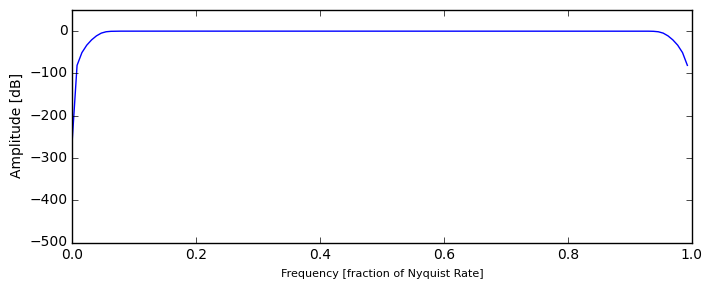

In [238]:
b, a = signal.butter(5, [0.05,0.95], 'bandpass', analog=False)
w, h = signal.freqz(b,a,128)

print 'numerator: ',b
print 'denominator: ',a

fig, axes = plt.subplots(figsize=(8,3),nrows=1, ncols=1)
current_axes = axes
current_axes.plot(w/math.pi, 20 * np.log10(abs(h)), 'b')
current_axes.set_ylabel('Amplitude [dB]', fontsize=10)
current_axes.set_xlabel('Frequency [fraction of Nyquist Rate]', fontsize=8)
current_axes.set_ylim([-500,50])

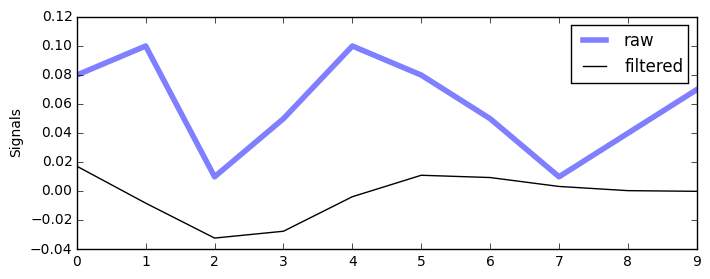

In [267]:
#sig_data = all_x_data[0]
#sig_data = all_y_data[0]
sig_data = all_z_data[0]

b, a = signal.butter(5, [0.1,0.50], 'bandpass', analog=False)
filt_data = signal.filtfilt(b,a,sig_data,padtype='odd',padlen=0)
#b, a = signal.butter(5, [0.95], 'low', analog=False)
#filt_data = signal.filtfilt(b,a,sig_data,padtype='odd',padlen=0)
#b, a = signal.butter(5, [0.05], 'high', analog=False)
#filt_data = signal.filtfilt(b,a,sig_data,padtype='odd',padlen=0)

fig, axes = plt.subplots(figsize=(8,3),nrows=1, ncols=1)
current_axes = axes
current_axes.plot(sig_data, linestyle='-', color='b', linewidth=4, alpha=0.5, label='raw')
current_axes.plot(filt_data, linestyle='-', color='k', linewidth=1, alpha=1.0, label='filtered')
current_axes.set_ylabel('Signals', fontsize=10)
current_axes.legend(loc='upper right')
#current_axes.set_xlabel('Frequency [fraction of Nyquist Rate]', fontsize=8)
#current_axes.set_ylim([-500,50])